Challenge: https://www.kaggle.com/competitions/tabular-playground-series-oct-2022

To Do:

1. Data Prep
    a. Download the training data (Let's start with train_0 - train_2)
    b. Size the dataset down; you should be able to use something akin to: `df.groupby('target_col').sample(frac=0.n)` where n=% of data we want to keep
    c. Compare distributions of training data to that of test data; use the ks2 test to determine if columns are of the same distribution
    d. Determine proper types for each column. Assume all numerical are float. Create a dictionary, `data_types`, where the `k` is the column and the `v` is the `pandas dtype` it should be

Resources needed:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
- https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/data
- https://seaborn.pydata.org/tutorial/distributions.html

2. Exploration
    a. Visualization
        i. For categorical, create histograms w/ KDE estimation, color by class
        ii. For continuous, create scatter (or cat) plot w/ class
        iii. For continuous, create histograms w/ KDE estimation, color by class
    b. Correlation
        i. Run correlation analysis on your columns (Spearman Correlation)
        ii. Plot the correlation heatmap
    c. Quality
        i. If column has a single unique value
        ii. If column is categorical, but has all unique values
        iii. If column is more than 50% NaN, null, or missing (Cabin)
        iv. If column is highly correlated with another    

Resources needed:
- https://seaborn.pydata.org/generated/seaborn.histplot.html
- https://seaborn.pydata.org/generated/seaborn.catplot.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
- https://seaborn.pydata.org/generated/seaborn.heatmap.html

3. Feature Engineering
    a. Feature Removal
        i. Determine which features can be removed from above analysis
    b. Feature Addition
        i. Consider creation of "lagging" features (i.e. over the last X timestamps, taking averages of numerical values/counts of categorical)
        ii. Create indicators for any missing or null data (if it exists)
        iii. Consider imputation methods

4. Modeling
    a. Optuna Framework
        - To be discussed on a Discord call


---



### Step 1: Data Prep


In [2]:
# This is using kaggle to download data into google colab (in /content)

# make sure kaggle.json file is present
# !ls -lha kaggle.json

# # Install kaggle API client
# !pip install -q kaggle

# # kaggle API client expects the file to be in ~/.kaggle

# # so move it there
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # we need to set permissions
# !chmod 600 /root/.kaggle/kaggle.json

# # check your directory before downloading the datasets
# !pwd

# # list all available datasets
# # !kaggle datasets list

# # download the required dataset from kaggle
# !kaggle competitions download -c tabular-playground-series-oct-2022

# # unzip
# !unzip tabular-playground-series-oct-2022.zip




In [3]:
import pandas as pd, numpy as np, seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


# dark mode savefig hides titles and axis on graphs
import matplotlib as mpl
mpl.rcParams["savefig.facecolor"] = "w"


In [4]:
train0 = pd.read_csv("train_0.csv")
train1 = pd.read_csv("train_1.csv")
train2 = pd.read_csv("train_2.csv")
test = pd.read_csv("test.csv")

In [5]:
train_sample = pd.concat([train0, train1, train2], axis=0)
df = train_sample.groupby("team_scoring_next").sample(frac=.03)
# df.drop('team_scoring_next', inplace=True, axis=1)



game_samples = train_sample[train_sample["game_num"] < 10]

In [6]:
# take2 with train and test all from train0.csv

x_train = train0.groupby('team_scoring_next').sample(frac=0.2).groupby('team_scoring_next').sample(frac=0.8)
idxs = x_train.index
x_test = train0.drop(idxs)

y_train = x_train['team_scoring_next']
x_train.drop('team_scoring_next', inplace=True, axis=1)

y_test = x_test['team_scoring_next']
x_test.drop('team_scoring_next', inplace=True, axis=1)

In [7]:
# free up memory
try:
  del train0
  del train1
  del train2
  del train_sample
except:
  pass

In [8]:
print("unique cols in test", [x for x in list(test.columns) if x not in set(df.columns)])
print("unique cols in train", [x for x in list(df.columns) if x not in set(test.columns)])
un_cols = [x for x in list(df.columns) if x not in set(test.columns)]
print(len(test), len(df))

unique cols in test ['id']
unique cols in train ['game_num', 'event_id', 'event_time', 'player_scoring_next', 'team_scoring_next', 'team_A_scoring_within_10sec', 'team_B_scoring_within_10sec']
701143 148112


In [9]:
# using ks2, we will check every col but unique cols 
# belive we can reject the null hyp if pvalue < .05, implying that the test and train are not same distribution
results = {}
for col in x_train.columns:
  if col not in un_cols:
    out = stats.ks_2samp(x_train[col], x_test[col])
    results[col] =  out
results

results2 = {}
for col in df.columns:
  if col not in un_cols:
    out = stats.ks_2samp(df[col], test[col])
    results2[col] =  out
results2

{'ball_pos_x': KstestResult(statistic=0.006572472625533621, pvalue=5.1405859091889566e-05),
 'ball_pos_y': KstestResult(statistic=0.004636064881690605, pvalue=0.010395793422460326),
 'ball_pos_z': KstestResult(statistic=0.002889067105639437, pvalue=0.2586585841040717),
 'ball_vel_x': KstestResult(statistic=0.0038886877711040713, pvalue=0.0494048658547549),
 'ball_vel_y': KstestResult(statistic=0.002255460602474557, pvalue=0.5618407881146159),
 'ball_vel_z': KstestResult(statistic=0.002720969320689992, pvalue=0.325080187840449),
 'p0_pos_x': KstestResult(statistic=0.003643443688105319, pvalue=0.07762803013736175),
 'p0_pos_y': KstestResult(statistic=0.003744497835735161, pvalue=0.06467013360749496),
 'p0_pos_z': KstestResult(statistic=0.00637102230349107, pvalue=9.727923491634151e-05),
 'p0_vel_x': KstestResult(statistic=0.0015372002487585856, pvalue=0.9343404784956709),
 'p0_vel_y': KstestResult(statistic=0.0030522875265361904, pvalue=0.20425027776440352),
 'p0_vel_z': KstestResult(sta

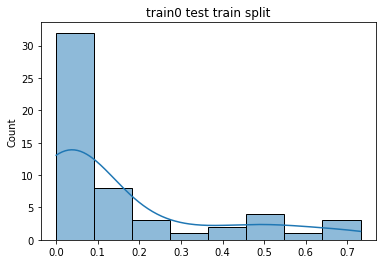

Text(0.5, 1.0, 'train0-train2 and test separate')

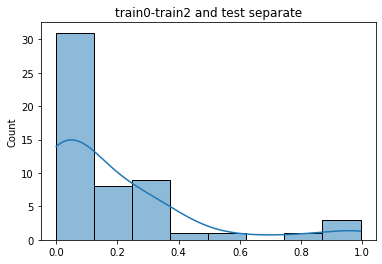

In [10]:
pvals = [r[1] for r in results.values()]
sns.histplot(x=pvals, kde=True, palette="dark")
plt.title("train0 test train split")
plt.show()
pvals = [r[1] for r in results2.values()]
sns.histplot(x=pvals, kde=True, palette="dark")
plt.title("train0-train2 and test separate")

In [11]:
# df = df.drop(["game_num", "event_time", "event_id"], axis=1)
data_types = {}
for col in df:
  data_types[col] = df[col].dtype.name
data_types["team_scoring_next"] = "int64"
data_types

{'game_num': 'int64',
 'event_id': 'int64',
 'event_time': 'float64',
 'ball_pos_x': 'float64',
 'ball_pos_y': 'float64',
 'ball_pos_z': 'float64',
 'ball_vel_x': 'float64',
 'ball_vel_y': 'float64',
 'ball_vel_z': 'float64',
 'p0_pos_x': 'float64',
 'p0_pos_y': 'float64',
 'p0_pos_z': 'float64',
 'p0_vel_x': 'float64',
 'p0_vel_y': 'float64',
 'p0_vel_z': 'float64',
 'p0_boost': 'float64',
 'p1_pos_x': 'float64',
 'p1_pos_y': 'float64',
 'p1_pos_z': 'float64',
 'p1_vel_x': 'float64',
 'p1_vel_y': 'float64',
 'p1_vel_z': 'float64',
 'p1_boost': 'float64',
 'p2_pos_x': 'float64',
 'p2_pos_y': 'float64',
 'p2_pos_z': 'float64',
 'p2_vel_x': 'float64',
 'p2_vel_y': 'float64',
 'p2_vel_z': 'float64',
 'p2_boost': 'float64',
 'p3_pos_x': 'float64',
 'p3_pos_y': 'float64',
 'p3_pos_z': 'float64',
 'p3_vel_x': 'float64',
 'p3_vel_y': 'float64',
 'p3_vel_z': 'float64',
 'p3_boost': 'float64',
 'p4_pos_x': 'float64',
 'p4_pos_y': 'float64',
 'p4_pos_z': 'float64',
 'p4_vel_x': 'float64',
 'p4_v

### Step 2: Exploration and Visualization

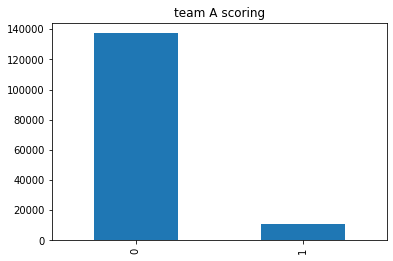

<AxesSubplot:title={'center':'team B scoring'}>

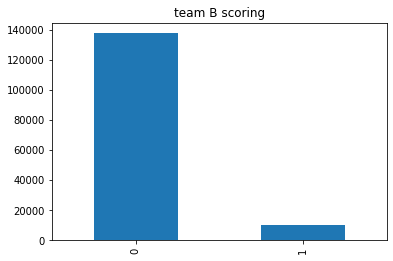

In [12]:

df["team_A_scoring_within_10sec"].value_counts().plot(kind="bar",  title="team A scoring")
plt.show()
df["team_B_scoring_within_10sec"].value_counts().plot(kind="bar",  title="team B scoring")

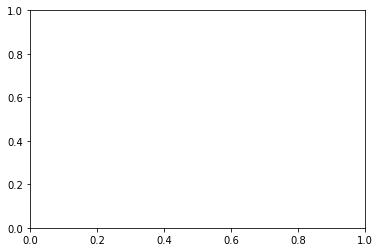

In [13]:
# saving off histograms


for col in df.columns:
    sns.histplot(x=df[col].values, kde=True, palette="dark", hue=df["team_scoring_next"].values)
    plt.suptitle(f"kde {col}")
    
    plt.savefig(f"kde_images/kde_{col}.png", bbox_inches="tight")
    plt.clf()
    plt.cla()
    
pass


In [19]:
# for col in df.columns:
#     sns.histplot(x=df[col].values, kde=True, palette="dark", hue=df["team_scoring_next"].values)
#     plt.suptitle(f"kde {col}")
    
#     plt.savefig(f"kde_images/kde_{col}.png", bbox_inches="tight")
#     plt.clf()
#     plt.cla()
sns.scatterplot(x=df["ball_pos_x"], y


,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
1223743,1904,1904001,-5.958181,-33.030200,-62.653000,6.210400,-22.992199,48.090600,31.507801,-31.284800,...,-7.965,0.0000,-7.727,0.0000,0.0000,-0.4841,2,A,1,0
321804,1590,1590001,-59.144955,72.543800,84.345990,25.449000,-10.347400,8.829400,24.767800,81.443400,...,-0.865,0.0000,-2.299,-0.4988,0.0000,-2.3980,1,A,0,0
1614450,554,554003,-63.335846,-4.609200,76.228400,18.585800,-37.864000,45.832798,-18.607399,33.436398,...,-2.268,0.0000,0.000,-4.4000,-7.6640,0.0000,0,A,0,0
1536402,1254,1254002,-53.307392,-25.057800,-31.148602,6.510200,11.534399,-8.458000,16.844398,17.777400,...,0.000,-8.8700,0.000,-4.6200,-1.9610,-1.3600,1,A,0,0
1360969,1951,1951004,-10.868188,-77.328200,5.015600,27.531200,13.629800,-29.596600,17.679201,-15.174600,...,0.000,0.0000,-0.785,-1.1190,-4.0980,0.0000,0,A,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87167,31,31004,-77.533660,-36.492000,99.363396,30.693000,38.790802,45.275200,3.673000,-17.299599,...,0.000,-6.1330,-5.332,-7.8000,-9.7660,-7.1330,4,B,0,0
2054772,707,707002,-85.933710,58.228600,-85.855995,21.248602,-18.730799,26.060200,-7.913600,35.120000,...,-3.232,-0.4666,-2.066,-3.3670,-0.3333,-6.2340,3,B,0,0
325287,850,850001,-118.559330,-41.390000,-11.360200,16.911000,-24.816599,33.794600,11.619399,-2.737600,...,0.000,0.0000,-9.600,-6.1640,-0.7905,-0.5234,3,B,0,0
274652,1573,1573001,-29.366049,-67.470604,30.988798,4.128000,8.868000,-35.267800,7.840400,68.737595,...,0.000,-5.2600,0.000,-9.3000,-8.8360,-5.6640,4,B,0,0


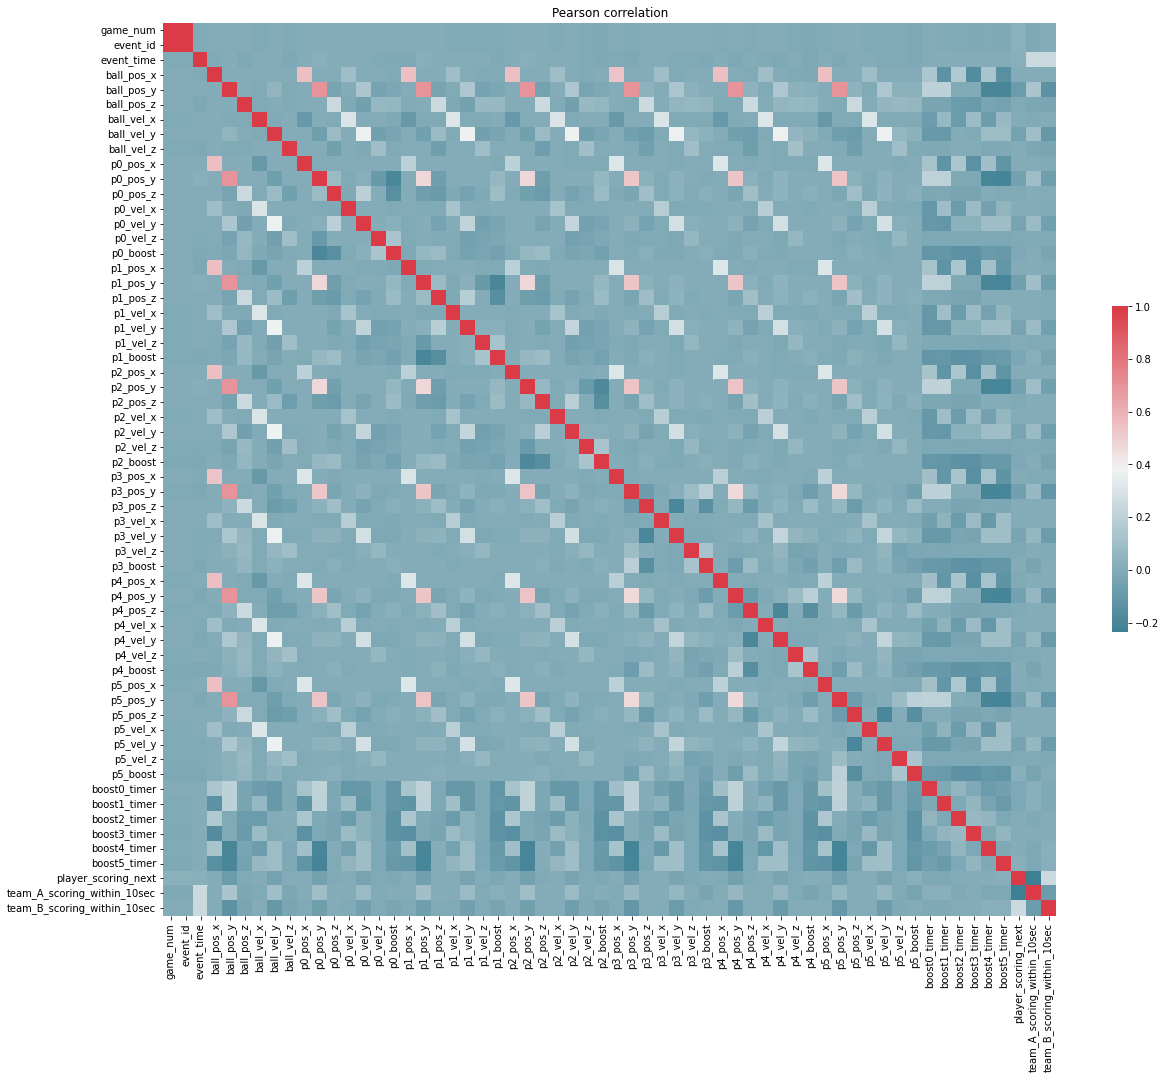

Text(0.5, 1.0, 'Spearman correlation')

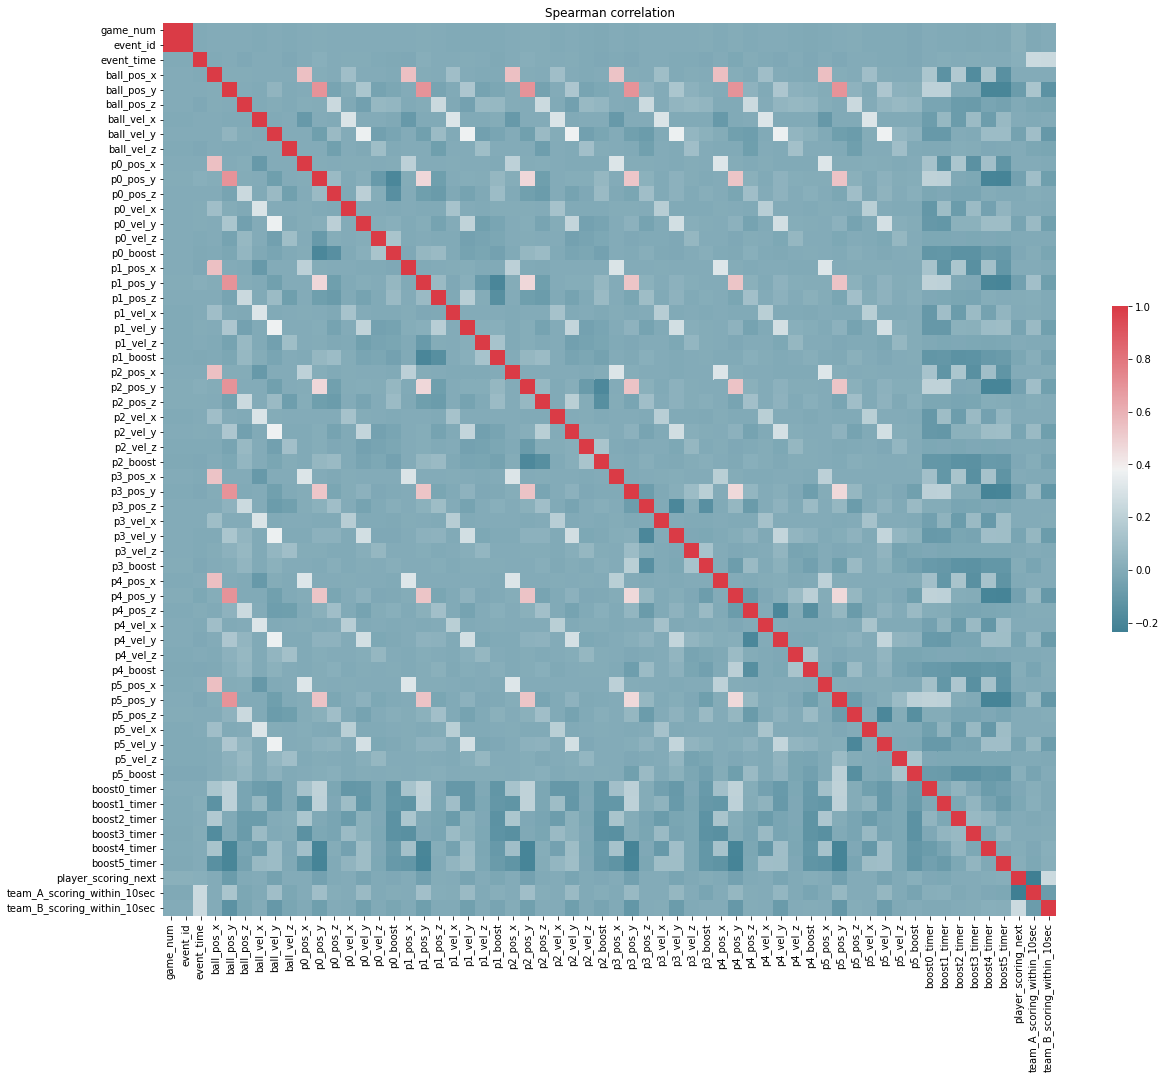

In [15]:
pearson_corr = df.corr()
spearman_corr = df.corr(method="spearman")

# heatmap = sns.heatmap(pearson_corr, vmin=-1, vmax=1, annot=True)
fig, ax = plt.subplots(figsize=(20, 20))                   # Sample figsize in inches

cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )  # color map
sns.heatmap(data      = pearson_corr, 
            cmap      = cmap, 
            square    = True, 
            cbar_kws  = {'shrink': .3}, 
            annot     = False, 
            annot_kws = {'fontsize': 12},
            ax        = ax
           )
plt.title("Pearson correlation")
plt.show()
fig, ax = plt.subplots(figsize=(20, 20)) 
# heatmap = sns.heatmap(spearman_corr, vmin=-1, vmax=1, annot=True)
sns.heatmap(data      = pearson_corr, 
            cmap      = cmap, 
            square    = True, 
            cbar_kws  = {'shrink': .3}, 
            annot     = False, 
            annot_kws = {'fontsize': 12},
            ax        = ax
           )
plt.title("Spearman correlation")


The divider

____ 


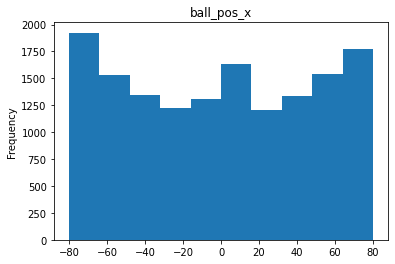

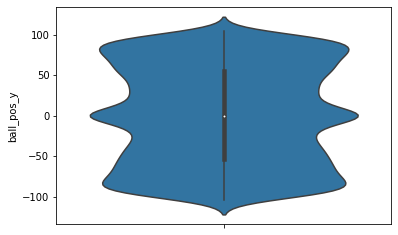

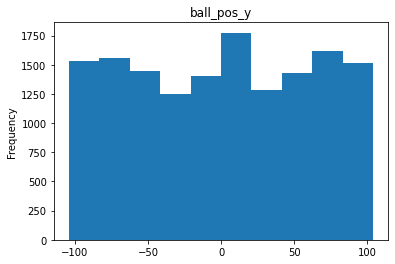

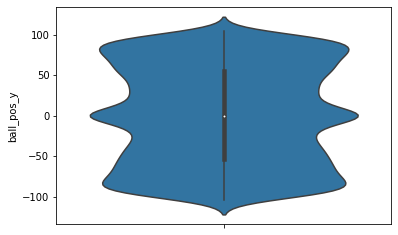

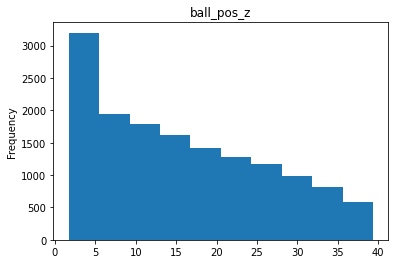

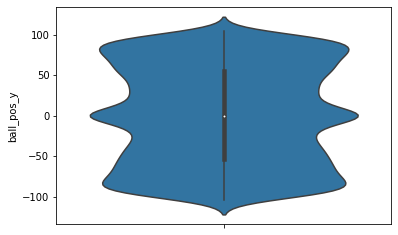

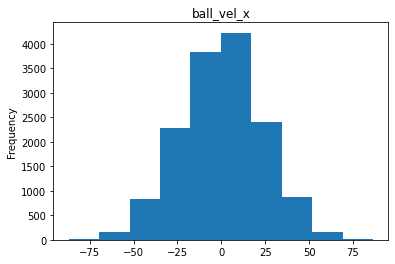

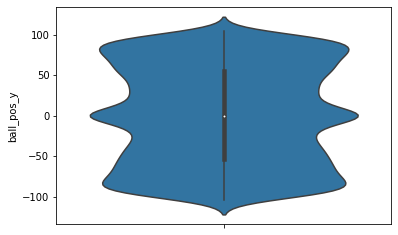

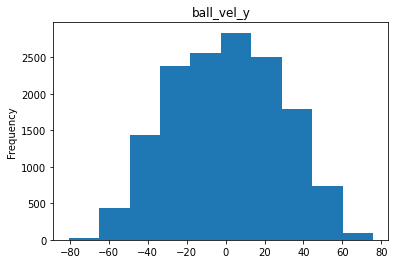

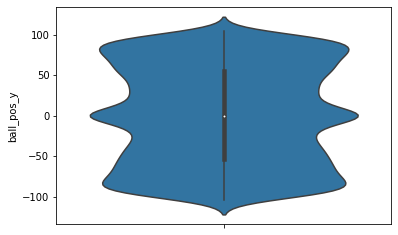

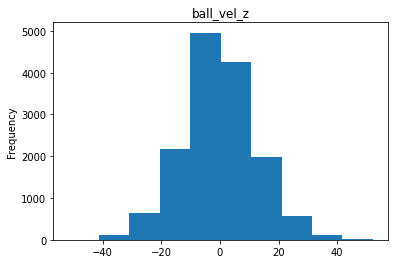

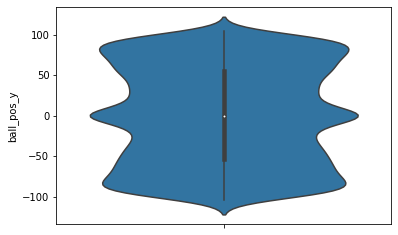

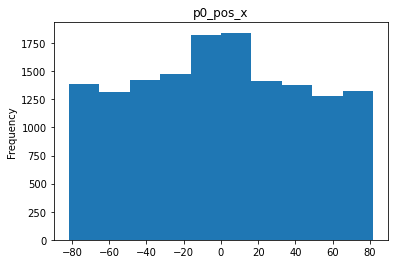

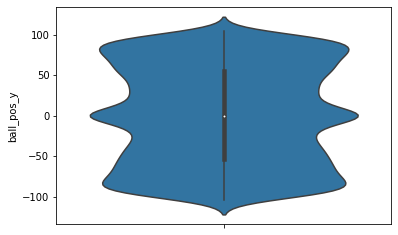

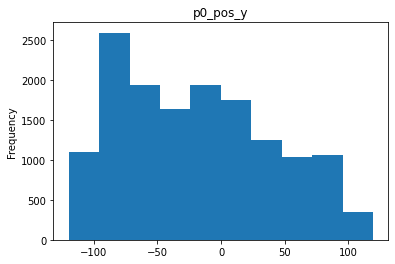

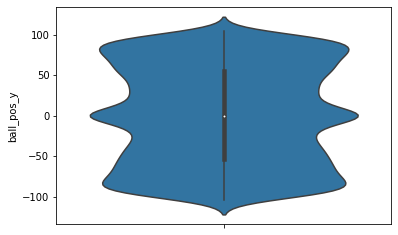

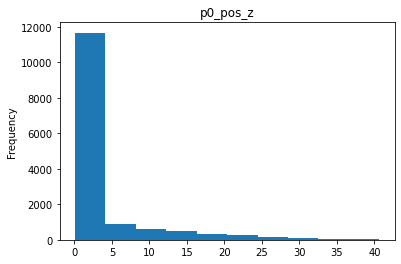

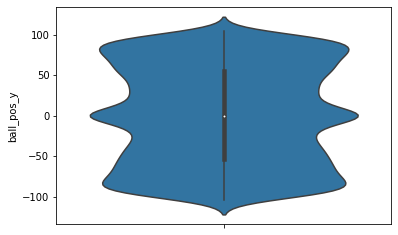

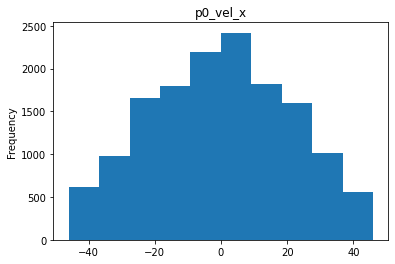

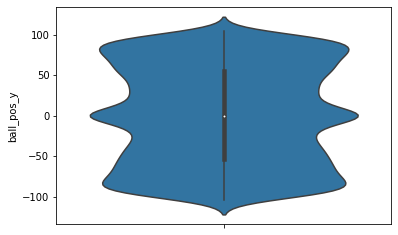

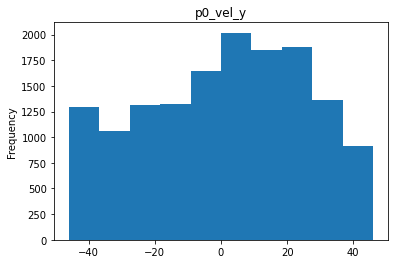

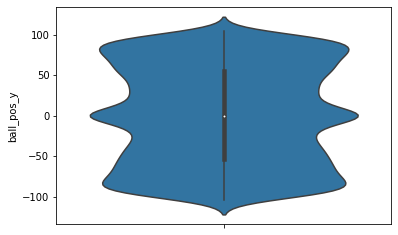

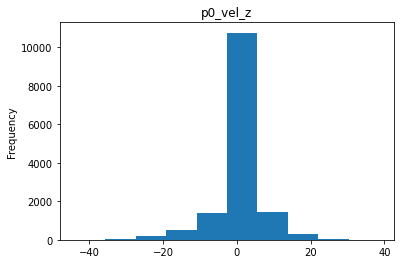

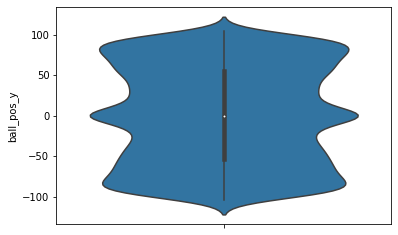

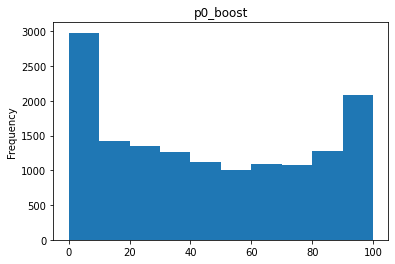

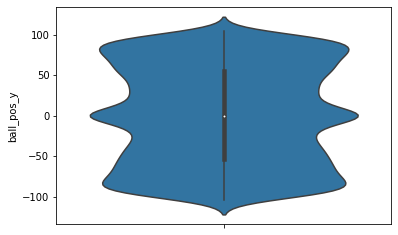

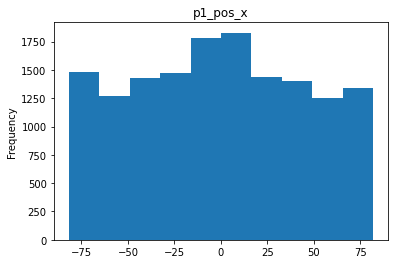

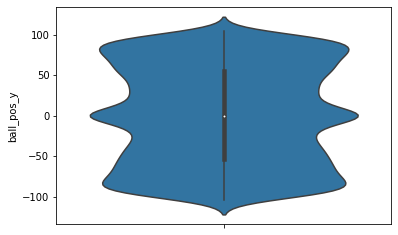

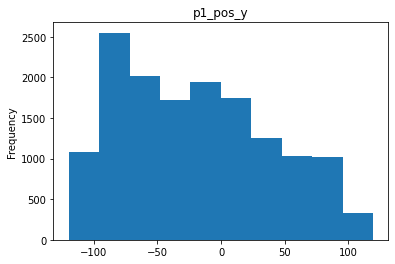

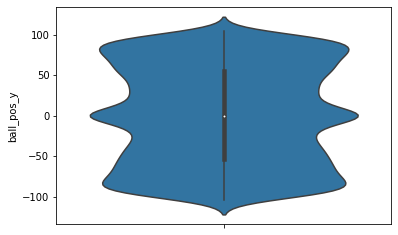

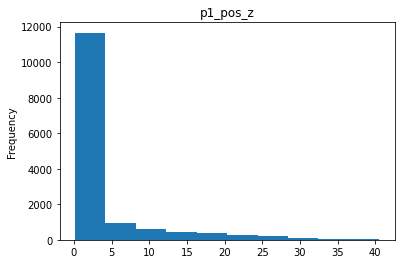

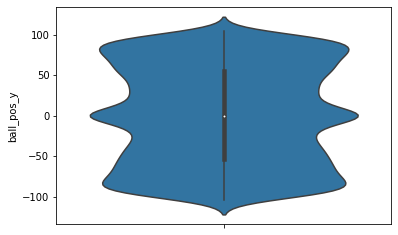

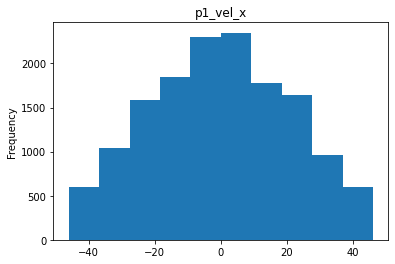

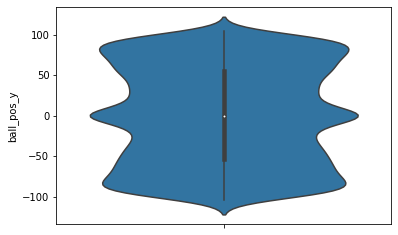

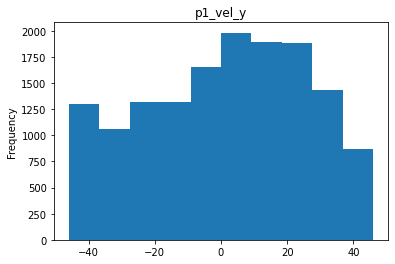

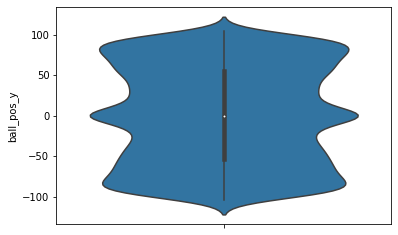

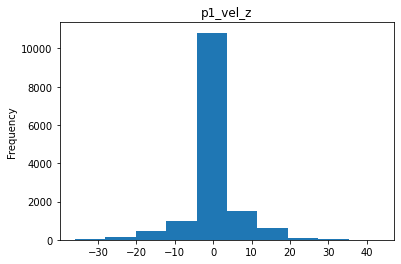

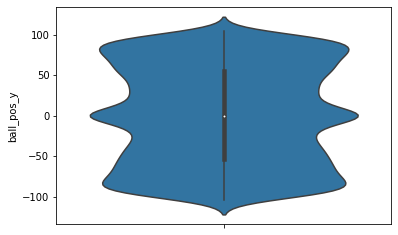

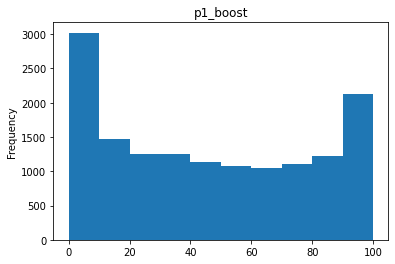

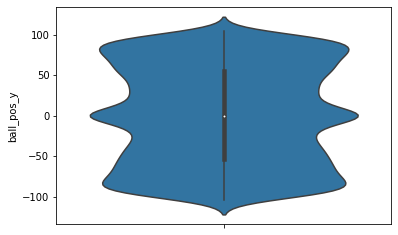

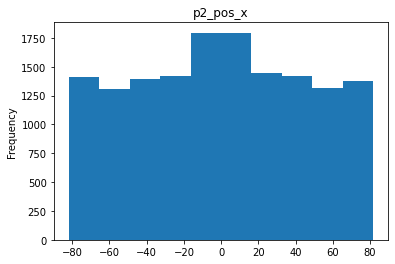

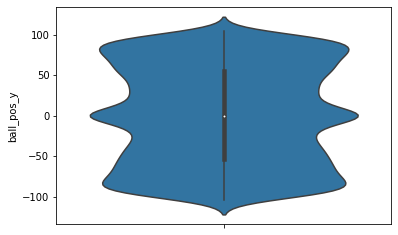

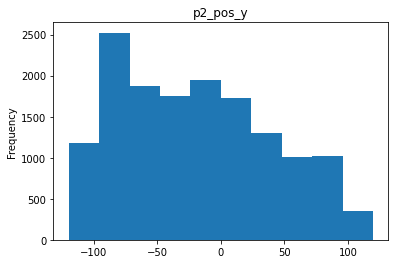

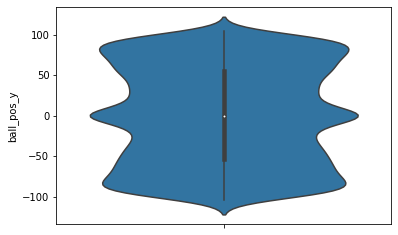

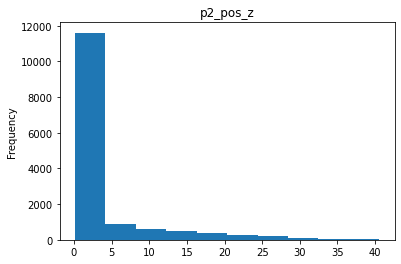

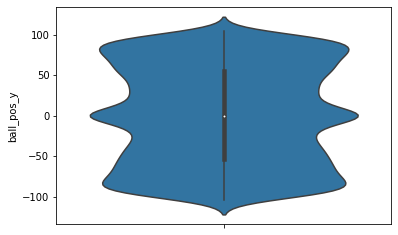

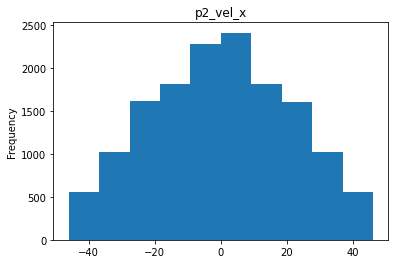

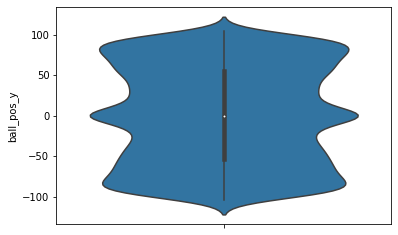

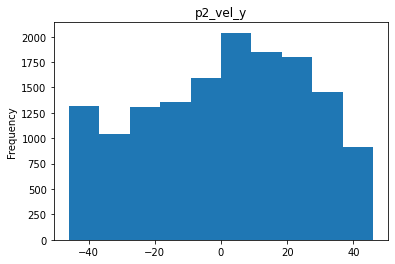

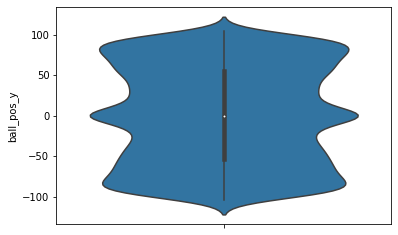

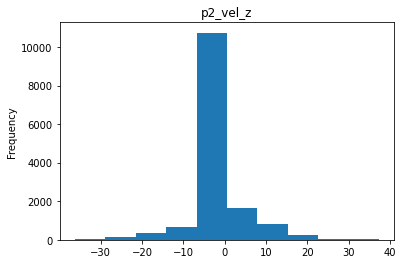

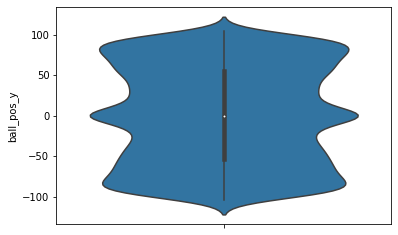

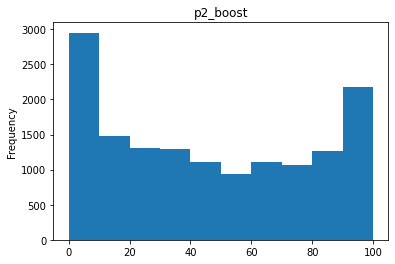

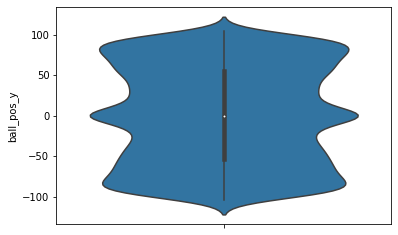

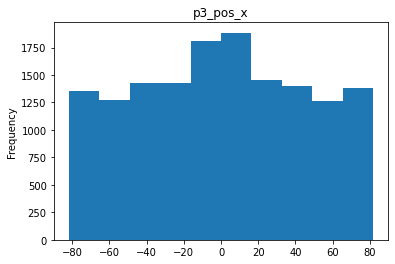

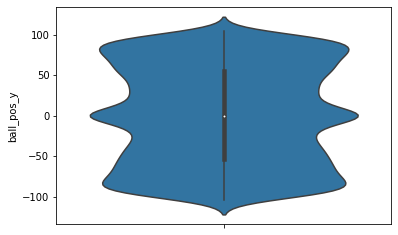

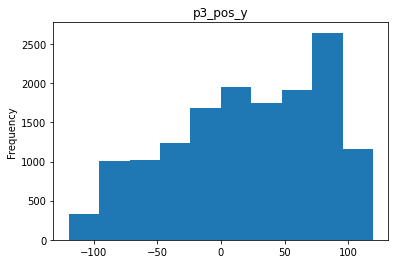

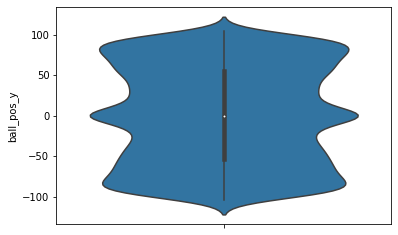

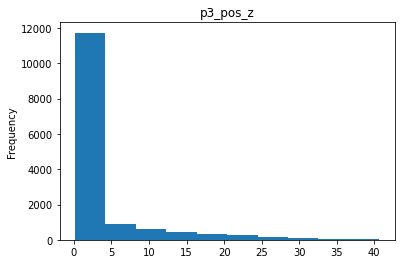

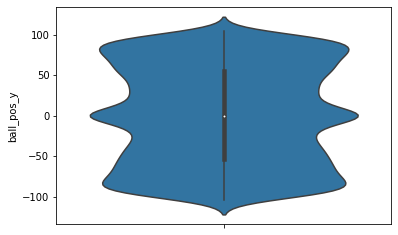

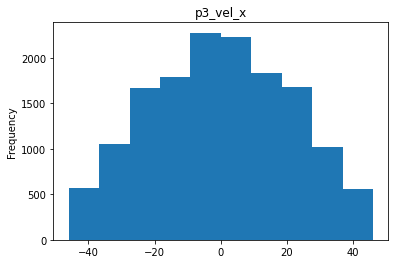

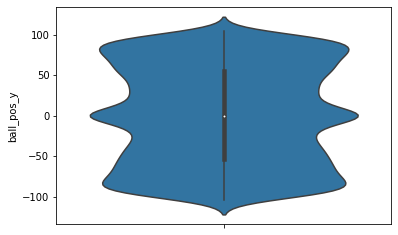

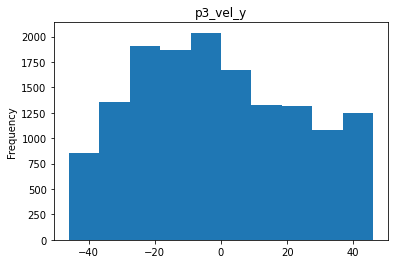

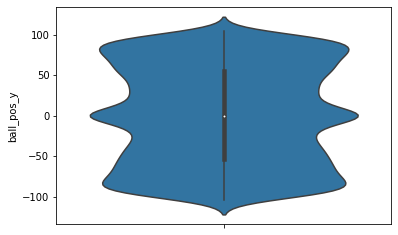

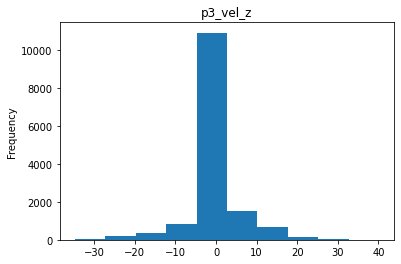

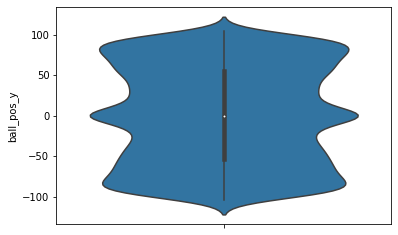

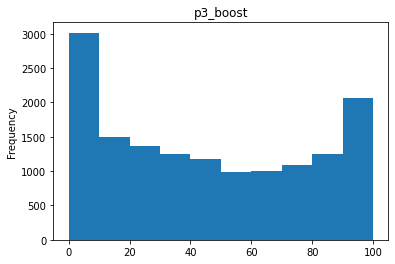

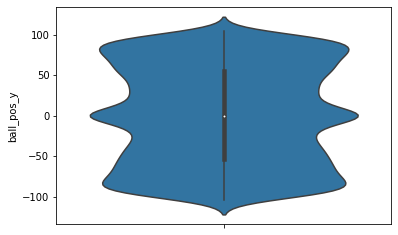

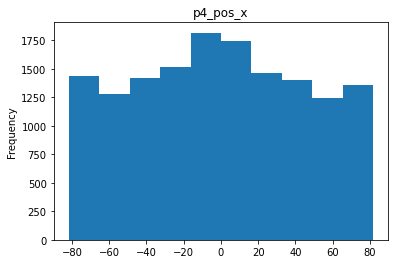

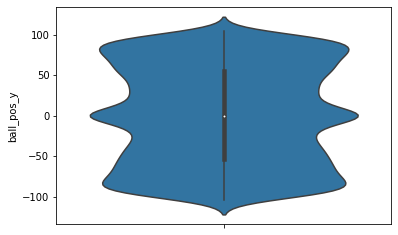

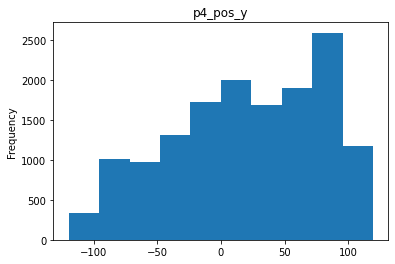

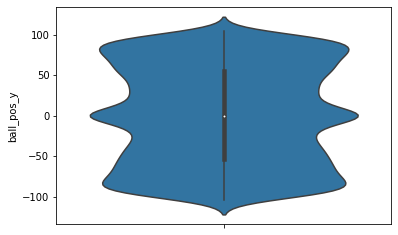

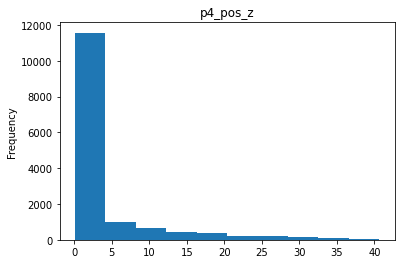

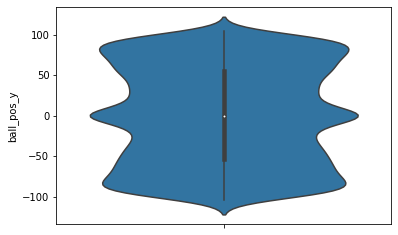

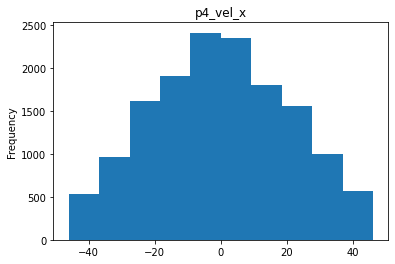

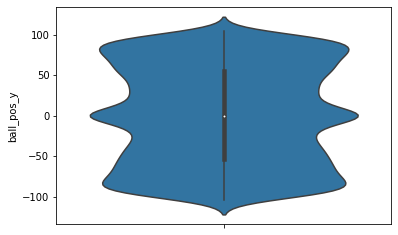

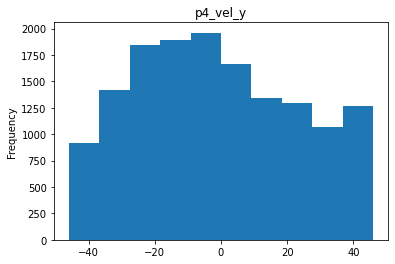

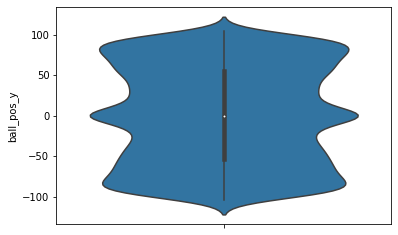

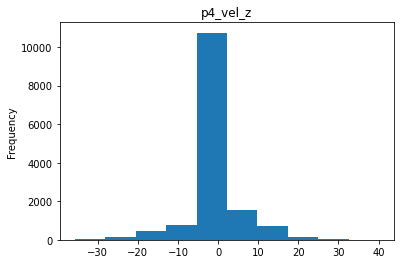

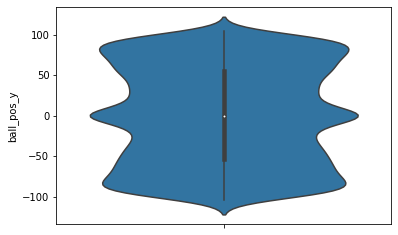

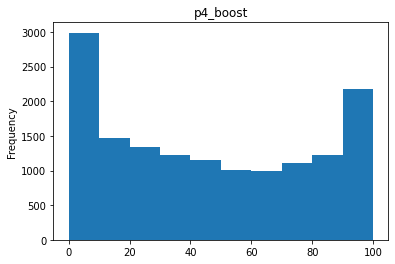

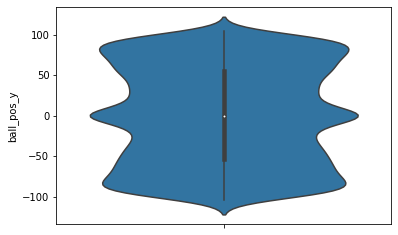

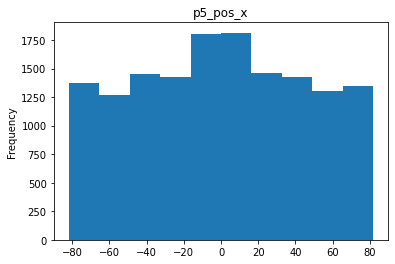

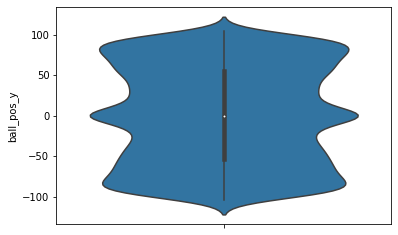

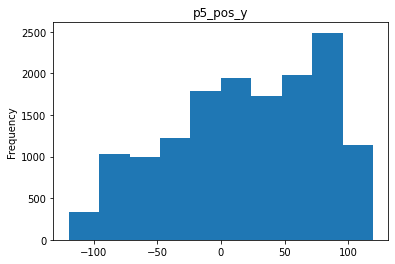

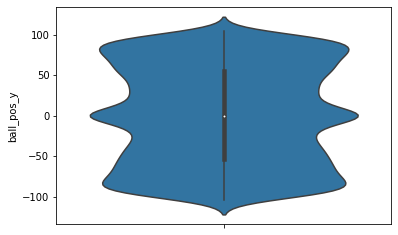

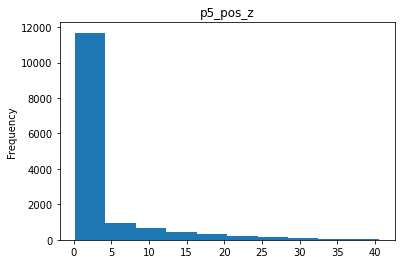

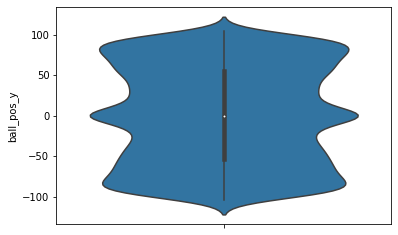

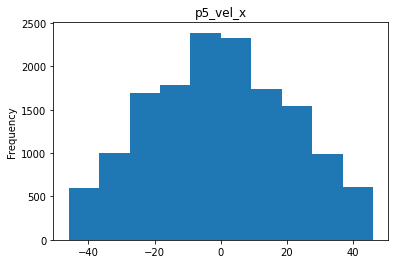

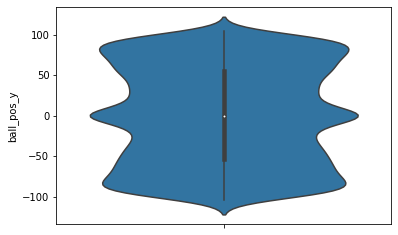

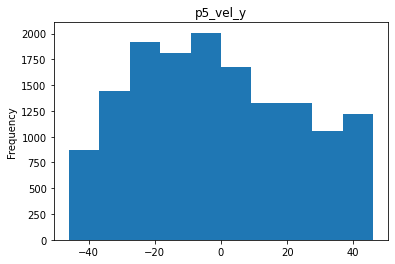

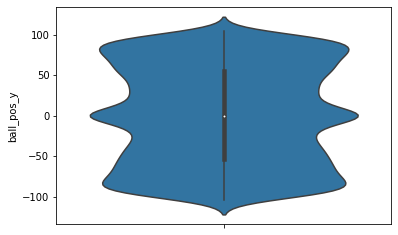

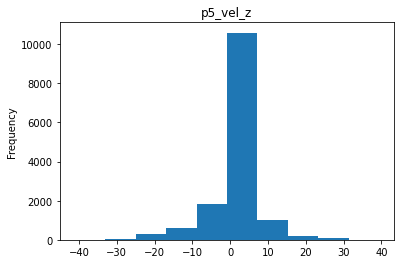

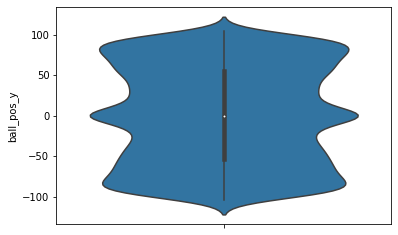

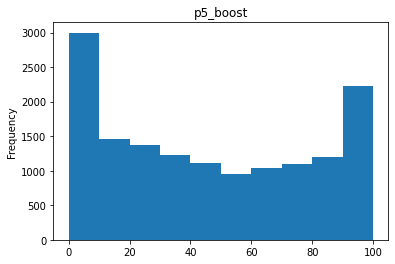

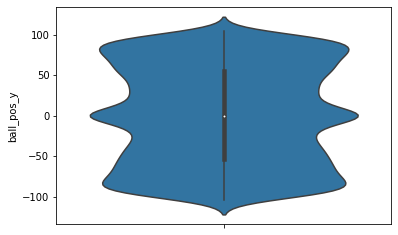

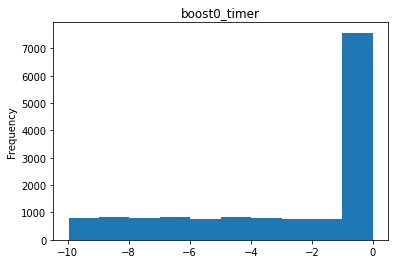

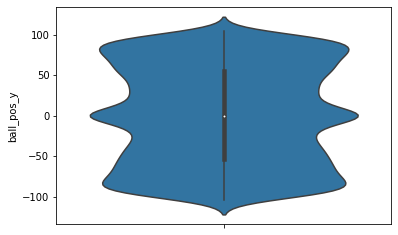

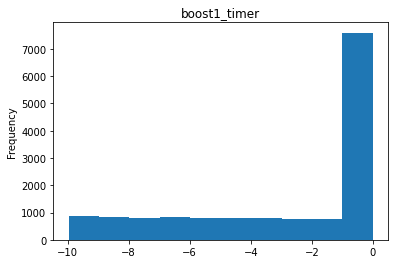

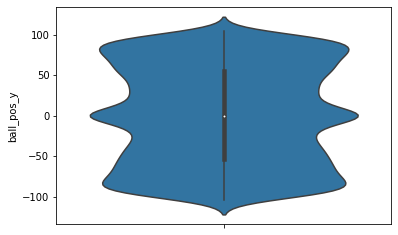

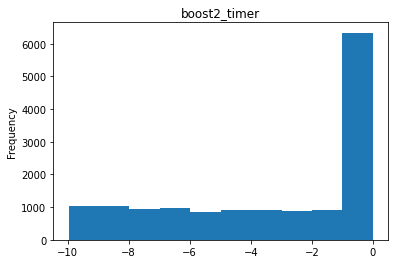

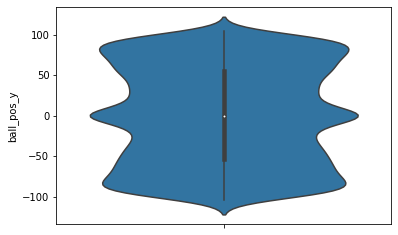

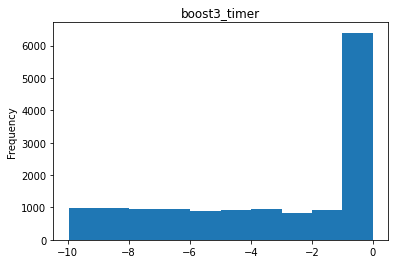

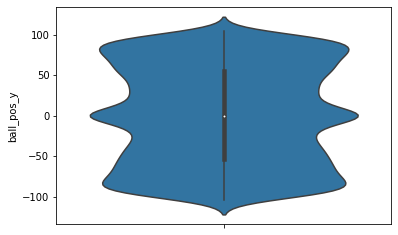

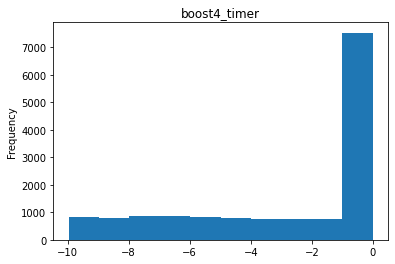

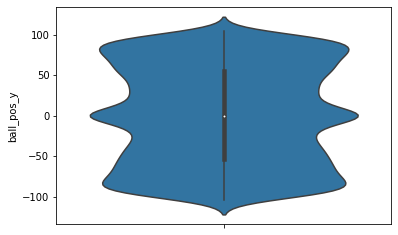

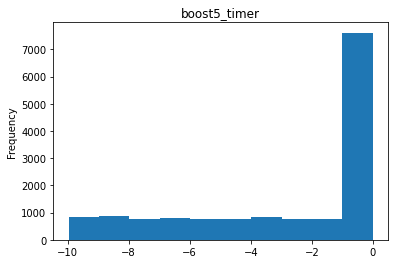

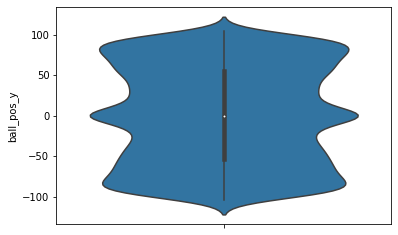

<Figure size 432x288 with 0 Axes>

In [16]:
small_df = df.groupby("team_scoring_next").sample(frac=.1)

# make histograms
for col in small_df:
  if col not in un_cols:
    small_df[col].plot(kind="hist",  title=col)

    plt.show()
    plt.cla()
    plt.clf()
    sns.violinplot(y=small_df["ball_pos_y"])
    plt.show()
    plt.cla()
    plt.clf()


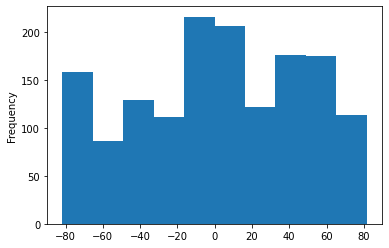

<Figure size 432x288 with 0 Axes>

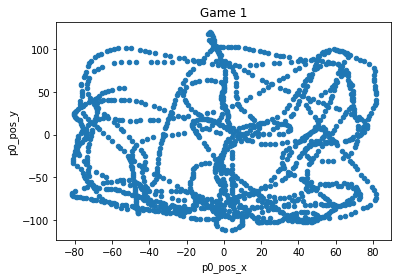

/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


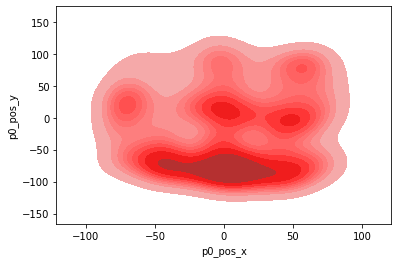

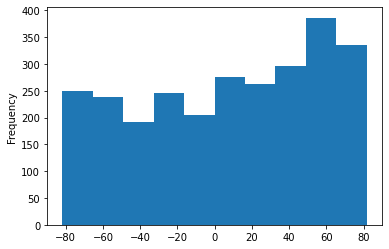

<Figure size 432x288 with 0 Axes>

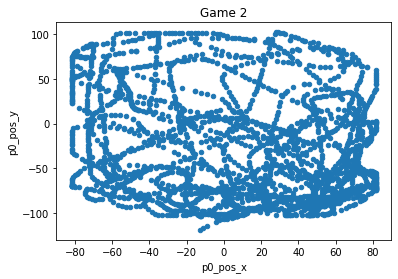

/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


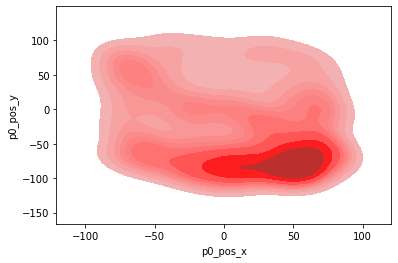

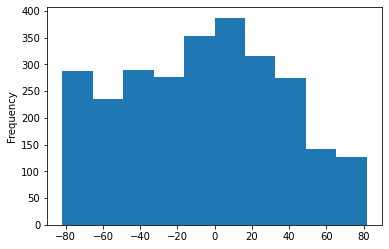

<Figure size 432x288 with 0 Axes>

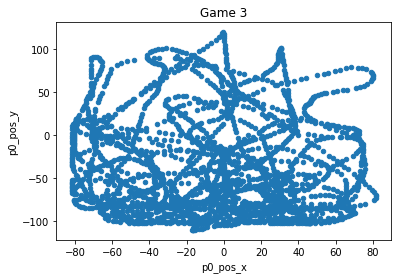

/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


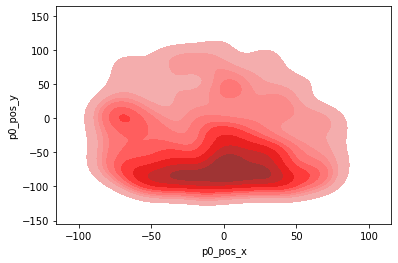

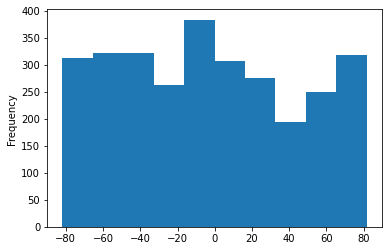

<Figure size 432x288 with 0 Axes>

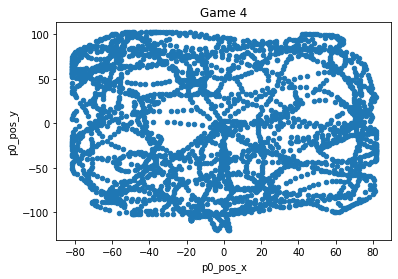

/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


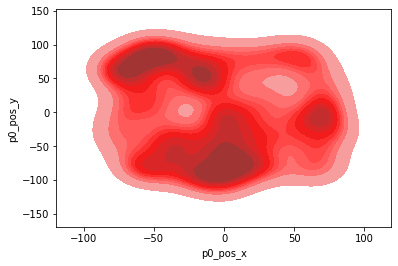

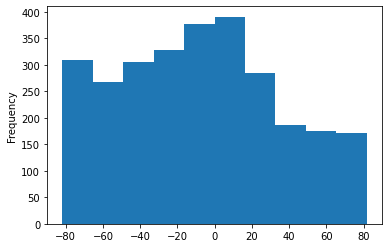

<Figure size 432x288 with 0 Axes>

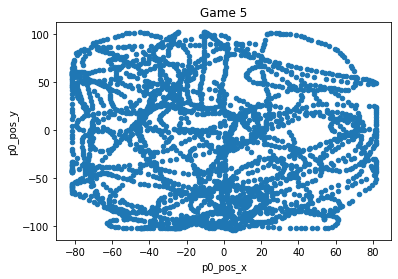

/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/c/Users/George/Documents/code/python/kaggle/rocket/lib/python3.6/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


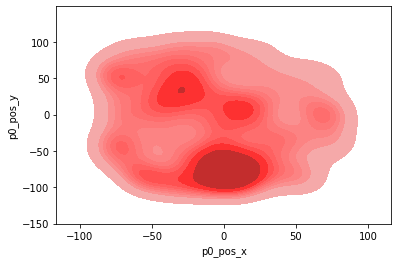

<Figure size 432x288 with 0 Axes>

In [17]:
# sns.heatmap()
# small_df.corr()
x_col = "p0_pos_x"
ycol = "p0_pos_y"

for i in range(1, 6):
  game2 = game_samples[game_samples["game_num"] == i]
  game2[x_col].plot(kind="hist")
  plt.show()
  plt.cla()
  plt.clf()
  game2[[x_col, ycol]].plot(kind="scatter", x=x_col, y =ycol, title=f"Game {i}")
  plt.show()
  plt.cla()
  plt.clf()
  # sns.violinplot(y=game2["ball_pos_y"])
  sns.kdeplot(game2[x_col], game2[ycol], shade=True, shade_lowest=False, color="r")
  # sns.heatmap(  game2[[x_col, ycol]].corr())
  plt.show()
  plt.cla()
  plt.clf()

### Make sure to remove scoring cols to not screw up results after viz stuff